In [ ]:
! pip install -q kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d nikhilroxtomar/person-segmentation
!unzip -q "person-segmentation.zip"
!rm -r "person-segmentation.zip"

 96% 442M/461M [00:05<00:00, 70.6MB/s]
100% 461M/461M [00:05<00:00, 82.4MB/s]


In [ ]:
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
masks = sorted(os.listdir('people_segmentation/masks'))
images = [os.path.sep.join(['people_segmentation', 'images', image.split(".png")[0]+".jpg"]) for image in masks]
masks = [os.path.sep.join(['people_segmentation', 'masks', image]) for image in masks]

In [ ]:
batch_size = 4

In [ ]:
img = []
mask = []
images_filename = []
masks_filename = []
for i in range(len(images)):
  img.append(images[i])
  mask.append(masks[i])
  if len(img) == batch_size:
    images_filename.append(img)
    masks_filename.append(mask)
    img = []
    mask = []
if img != []:
  images_filename.append(img)
  masks_filename.append(mask)
  img = []
  mask = []

In [ ]:
print(len(images_filename))
print(len(masks_filename))

1420
1420


In [ ]:
from tensorflow import keras

In [ ]:
class Generator(keras.utils.Sequence):
  def __init__(self, num_batches,image_filenames, masks_filename):
    self.num_batches = num_batches
    self.image_filenames = image_filenames
    self.masks_filename = masks_filename
  def __len__(self):
      return self.num_batches
  def __getitem__(self, idx):
    image_batch = []
    mask_batch = []
    for i in range(len(self.image_filenames[idx])):

      img = Image.open(self.image_filenames[idx][i])
      img = np.array(img)
      img = cv2.resize(img, (224, 224))
      

      mask = cv2.imread(self.masks_filename[idx][i])[:, :, 0]
      mask = cv2.resize(mask,(224, 224))

      image_batch.append(img)
      mask_batch.append(mask)
    image_batch = np.array(image_batch, dtype=np.float32) / 255.0
    mask_batch = np.array(mask_batch)
    return image_batch, mask_batch



In [ ]:
MySequenceGenerator = Generator(len(images_filename) ,images_filename, masks_filename)

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

In [ ]:
def get_unet(DropoutRate = 0.5):
    #learningRate = 0.001
    inputs = Input((224, 224, 3))

    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(DropoutRate)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(DropoutRate)(conv5)

    up6 = Conv2D(512, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9],  axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)

    #model.compile(optimizer=Adam(lr=learningRate), loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model
#K.clear_session()
#model = get_unet()
#print(model.summary())

In [ ]:

from tensorflow.keras import layers
from tensorflow import keras
def unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        #x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        #x = layers.DepthwiseConv2D(filters, 3, padding="same")(x)
        
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        
        x = layers.Conv2D(filters, 3, padding="same")(x)
        #x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        #x = layers.DepthwiseConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual]) 
        previous_block_activation = x  

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)
    # outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

keras.backend.clear_session()

model = unet_model((224, 224), num_classes=1)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#model.fit_generator(generator=MySequenceGenerator, epochs = 10, verbose = 1, workers = 8)
model.fit(MySequenceGenerator, epochs = 50)

Epoch 1/50
1420/1420 [==============================] - 99s 68ms/step - loss: 0.9586 - accuracy: 0.7724
Epoch 2/50
1420/1420 [==============================] - 97s 68ms/step - loss: 0.3644 - accuracy: 0.8401
Epoch 3/50
1420/1420 [==============================] - 97s 68ms/step - loss: 0.3117 - accuracy: 0.8671
Epoch 4/50
1420/1420 [==============================] - 97s 68ms/step - loss: 0.2781 - accuracy: 0.8837
Epoch 5/50
1420/1420 [==============================] - 96s 68ms/step - loss: 0.2422 - accuracy: 0.9008
Epoch 6/50
1420/1420 [==============================] - 96s 68ms/step - loss: 0.2194 - accuracy: 0.9097
Epoch 7/50
1420/1420 [==============================] - 96s 68ms/step - loss: 0.2121 - accuracy: 0.9137
Epoch 8/50
1420/1420 [==============================] - 97s 68ms/step - loss: 0.1853 - accuracy: 0.9251
Epoch 9/50
1420/1420 [==============================] - 97s 68ms/step - loss: 0.1749 - accuracy: 0.9282
Epoch 10/50
1420/1420 [==============================] - 97s 68m

In [ ]:
model.save('model.h5')

In [ ]:
!wget "https://www.businessinsider.in/thumb/msid-79190983,width-600,resizemode-4,imgsize-150107/india/news/bollywood-actor-asif-basra-commits-suicide-in-dharamshala/asif-basra.jpg"
!wget "https://static.india.com/wp-content/uploads/2020/12/how-scam-1992-the-harshad-mehta-story-changed-pratik-gandhi-life-forever-main.jpg"
!wget "https://bsmedia.business-standard.com/_media/bs/img/article/2020-04/29/full/1588142598-52.jpg"

--2021-02-24 09:44:33--  https://www.businessinsider.in/thumb/msid-79190983,width-600,resizemode-4,imgsize-150107/india/news/bollywood-actor-asif-basra-commits-suicide-in-dharamshala/asif-basra.jpg
Resolving www.businessinsider.in (www.businessinsider.in)... 104.92.250.49, 2600:1409:12:482::3621, 2600:1409:12:49d::3621
Connecting to www.businessinsider.in (www.businessinsider.in)|104.92.250.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19699 (19K) [image/jpeg]
Saving to: ‘asif-basra.jpg’

asif-basra.jpg      100%[===================>]  19.24K  --.-KB/s    in 0.007s  

2021-02-24 09:44:33 (2.86 MB/s) - ‘asif-basra.jpg’ saved [19699/19699]

--2021-02-24 09:44:34--  https://static.india.com/wp-content/uploads/2020/12/how-scam-1992-the-harshad-mehta-story-changed-pratik-gandhi-life-forever-main.jpg
Resolving static.india.com (static.india.com)... 23.39.22.159, 2600:1409:12:499::2965, 2600:1409:12:488::2965
Connecting to static.india.com (static.india.com)|23.

In [ ]:
img = Image.open("asif-basra.jpg")
img = cv2.resize(np.array(img), (224, 224))
img = img / 255.0
predict = model.predict(img.reshape(1,224, 224, 3))

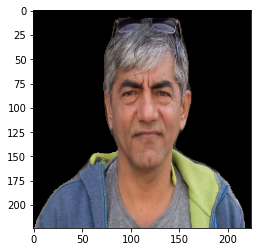

In [ ]:
ret,thresh2 = cv2.threshold(predict.reshape(224, 224),0.05,255,cv2.THRESH_BINARY)
img2 = img * 255
thresh2 = cv2.bitwise_and(img2.astype(np.uint8), img2.astype(np.uint8), mask=thresh2.astype(np.uint8))
plt.imshow(thresh2, cmap="gray")

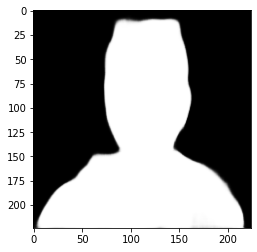

In [ ]:
plt.imshow(predict.reshape(224, 224), cmap="gray")

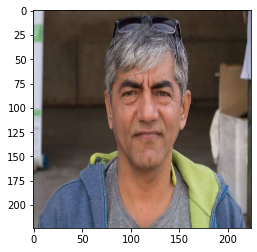

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
img = Image.open("how-scam-1992-the-harshad-mehta-story-changed-pratik-gandhi-life-forever-main.jpg")
img = cv2.resize(np.array(img), (224, 224))
img = img / 255.0
predict = model.predict(img.reshape(1,224, 224, 3))

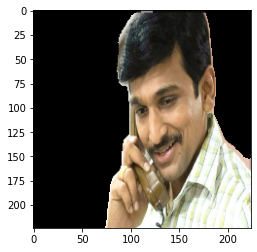

In [ ]:
ret,thresh2 = cv2.threshold(predict.reshape(224, 224),0.05,255,cv2.THRESH_BINARY)
img2 = img * 255
thresh2 = cv2.bitwise_and(img2.astype(np.uint8), img2.astype(np.uint8), mask=thresh2.astype(np.uint8))
plt.imshow(thresh2, cmap="gray")

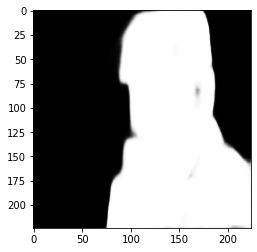

In [ ]:
plt.imshow(predict.reshape(224, 224), cmap="gray")

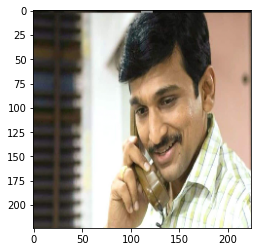

In [ ]:
plt.imshow(img, cmap="gray")

In [ ]:
img = Image.open("1588142598-52.jpg")
img = cv2.resize(np.array(img), (224, 224))
img = img / 255.0
predict = model.predict(img.reshape(1,224, 224, 3))

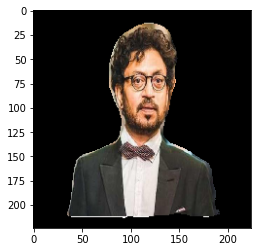

In [ ]:
ret,thresh2 = cv2.threshold(predict.reshape(224, 224),0.05,255,cv2.THRESH_BINARY)
img2 = img * 255
thresh2 = cv2.bitwise_and(img2.astype(np.uint8), img2.astype(np.uint8), mask=thresh2.astype(np.uint8))
plt.imshow(thresh2, cmap="gray")

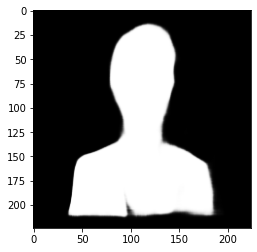

In [ ]:
plt.imshow(predict.reshape(224, 224), cmap="gray")

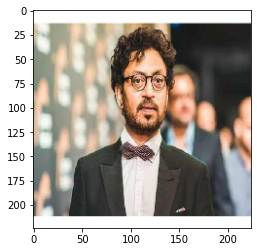

In [ ]:
plt.imshow(img, cmap="gray")